# Analyzing a Solar Spectrum from the Pasco Spectrometer

The data from the spectrometer is comma-separated values. It also has labels in the first row. We'll need to skip those when we read the data into arrays.'

In [1]:
import csv
wavelength = []
intensity = []
with open('/home/nbuser/sun2a.csv', newline='') as csvfile:
    has_header = csv.Sniffer().has_header(csvfile.read(1024)) # The file has a header of labels "Wavelength (nm)" and "Intensity"
    csvfile.seek(0)  # rewind to beginning of file
    incsv = csv.reader(csvfile) #read into memory
    if has_header:
        next(incsv)  # skip header row
    PascoSpectrum = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in PascoSpectrum:
        #print(row[0])
        wavelength.append(float(row[0]))
        intensity.append(float(row[1]))
#        print(', '.join(row))


Let's plot the data to make sure it read into Jupyter correctly.'

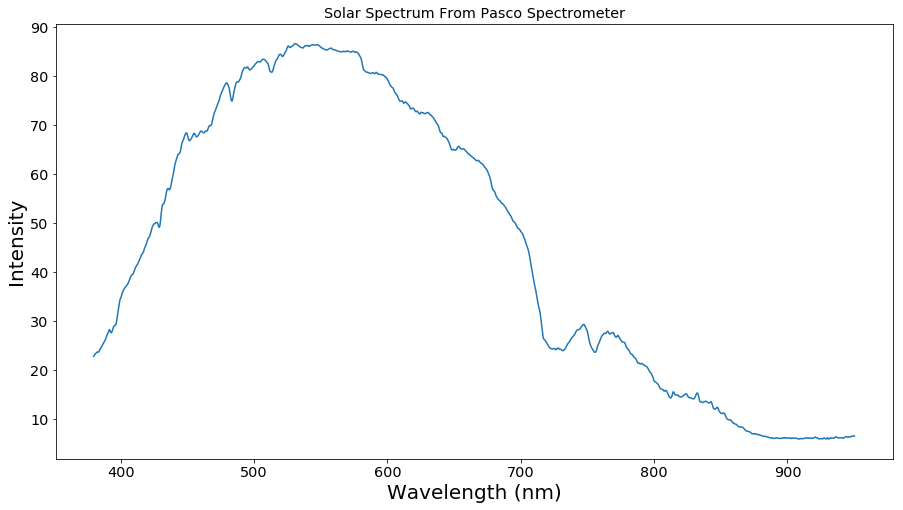

In [2]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
params = {'legend.fontsize': '16',
          'figure.figsize': (15, 8),
         'axes.labelsize': '20',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
plt.plot(wavelength, intensity)
plt.title('Solar Spectrum From Pasco Spectrometer')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.show()

To analyze this, we probably should convert to numpy arrays because native Python arrays are just lists with no numerical association.

In [3]:
wl_np = np.array(wavelength)
int_np = np.array(intensity)

To fit this spectrum to the blackbody (Planck) spectrum, we first need to know the spectrum intensity as a mathematical function of wavelength.
$$I\left(\lambda, T\right)d\lambda=\frac{2hc^2}{\lambda^5}\frac{1}{\rm{e}^\frac{hc}{\lambda kT}-1} d\lambda$$
This is the energy density, and the differential means we can calculate the total energy per volume if we integrate. Our approach is simpler. We only need to realize the integrand is the intensity as a function of wavelength and temperature. All of the constants can be assigned. Our curve-fitting will adjust the temperature and an amplitude parameter to find the best fit. The amplitude is an arbitrary fit parameter because we do not know exactly how much of the solar energy should strike the sensor. That is a function of distance from the sun, sensor size and sensitivity, atmospheric conditions, and probably a lot of other factors.

In [4]:
from numpy import array, arange, pi, exp, sin, cos, polyfit, poly1d, linspace, zeros, flipud
from matplotlib.pyplot import *
import scipy
from scipy.optimize import curve_fit
from scipy.optimize import fmin
from scipy.optimize import leastsq
import scipy.optimize as optimization

There are a variety of ways to use scipy to fit data. We will use the optimize.curve_fit library, but know you could use fmin, least_sq, etc. with some slight differences in implementation.

We will need to make initial guess at the amplitude and temperature. Notice the amplitude is defined as

$$\frac{2hc^2}{\lambda^5}$$

The $\lambda$ is a some positive variable number, $h, c, k$ are positive constants, and the exponential has a range from 0 to $\infty$ as temperature goes from $\infty$ to zero. This means the fraction with the exponential goes between zero when $T=0$, and it is $\infty$ when $T=\infty$. This means the energy emitted in electromagnetic radiation due to the blackbody is zero at $T=0$ and infinite at $T=\infty$, which makes perfect sense. We are looking at the sun, which has a set surface temperature when we measure the spectrum. That temperature is $0<T<\infty$. The exponential term is greater than or equal to 1 when

$$\rm{e}^{\frac{hc}{\lambda kT}}\ge 1$$
$$\frac{hc}{\lambda kT} \ge \rm{ln}\left(1\right)$$
$$\frac{hc}{\lambda kT} \ge 0$$

Since all of the values are positive, this is always true. Thus, the fraction with the exponential term is always greater than or equal to zero.

Back to the leading coefficient... When the wavelength is around 550 nm as we see for our measured spectrum, this coefficient evaluates to

$$\frac{2hc^2}{\lambda^5} = \frac{2\times6.63\times10^{-34}\times \left(3\times10^8\right)^2}{\left(550\times10^{-9}\right)^5}=2.4\times10^{15}$$

Our data shown above has a maximum of around 100 in intensity. Therefore, we expect the amplitude parameter to be in the neighborhood of $10^{-13}$ because our fit function will look something like

$$a \frac{2hc^2}{x^5} \frac{1}{\rm{e}^{\frac{hc}{x k b}}-1},$$

where a is the amplitude fit parameter, b is the temperature, and x is our dependent variable of wavelength. We know the sun's surface temperature is in thousands of Kelvin.

In [29]:
import math
x0=[1.0e-13, 1000.0] #Initial guesses for amplitude and temperature in Kelvin
sigma = [] #create a place to store the least squares values
wl_nm = [] #create a place to convert wavelength to meters

for count in range(0, len(intensity)):
    sigma.append(1) #fill the sigma array with 1 in every row
    if intensity[count]<70: # we could create a weight that favors some data points
        sigma[count] = 1e-10
    wl_nm.append(float(wavelength[count]*1e-9)) #convert wavelength to meters

x0 = np.array(x0) #convert our arrays to numbers
sig = np.array(sigma)
wl_nm = np.array(wl_nm)

def blackbody(x, a, b):
    h = 6.626E-34
    c = 3.0E8
    kB = 1.381E-23
    return a*h*c*c/(x)**5 * 1/(exp(h*c/(kB*(x)*b))-1)

result = optimization.curve_fit(blackbody, wl_nm, intensity, x0, sig)
print(sig)
print(result)

[  1.00000000e-10   1.00000000e-10   1.00000000e-10 ...,   1.00000000e-10
   1.00000000e-10   1.00000000e-10]
(array([  2.07812867e-12,   6.54730788e+03]), array([[  5.66814617e-27,  -4.07277544e-12],
       [ -4.07277544e-12,   3.13724374e+03]]))


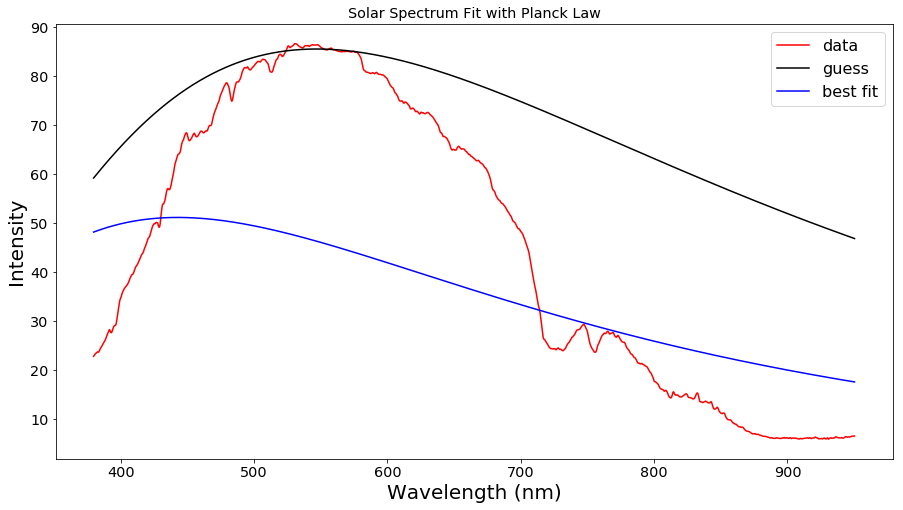

In [30]:
y=blackbody(wl_nm, 1e-11, 5300)
y2=blackbody(wl_nm, result[0][0],result[0][1])
plt.title('Solar Spectrum Fit with Planck Law')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.plot(wavelength, intensity, 'r', label='data') #need to add a label if we want a legend.
plt.plot(wavelength, y, 'k', label='guess')
plt.plot(wavelength, y2, 'b', label='best fit')
plt.legend(loc=1) #loc 1 is upper right, loc 2 is upper left, loc 3 is lower left, loc 4 is lower right
plt.show()

Wow! The fit is pretty bad. You should come up with some reasons why. It appears the peak is at lower wavelengths than it should be. What does this do to the temperature? Our fit says the sun's surface temperature is 6505 K. How do I get this? What is the amplitude parameter? Is it close to what you expected?

Notice there are a lot of dips in the spectrum. These are real and due to what are known as "Fraunhofer lines". You can read about Fraunhofer lines on Wikipedia (https://en.wikipedia.org/wiki/Fraunhofer_lines). The list of lines is on that website. Let's label our graph with those just like the Wikipedia graph.

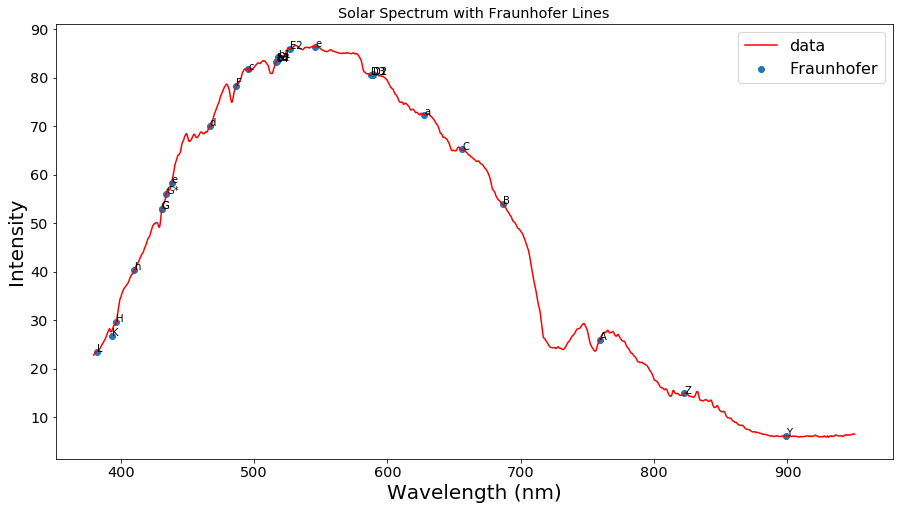

In [18]:
FraunhoferX=[382, 393.4, 396.8, 410.2, 430.774, 430.79, 434.047, 438.355, 466.814, 486.134, 495.761, 516.733, 516.891, 517.27, 518.362, 527.039, 546.073, 587.5618, 588.995, 589.592, 627.661, 656.281, 686.719, 759.37, 822.696, 898.765]
FraunhoferY=[23.5, 26.7, 29.6, 40.3, 52.9, 52.9, 56, 58.3, 70, 78.3, 81.7, 83.3, 83.4, 83.5, 84.2, 85.9, 86.4, 80.6, 80.7, 80.6, 72.4, 65.2, 54, 26, 14.9, 6.1]
FraunLabel=['L', 'K', 'H', 'h', 'G', 'G', 'G*', 'e', 'd', 'F', 'c', 'b4', 'b3', 'b2', 'b1', 'E2', 'e', 'D3', 'D2', 'D1', 'a', 'C', 'B', 'A', 'Z', 'Y']

fig, ax = plt.subplots()#(1,1,figsize=(20,20))
ax.plot(wavelength, intensity, 'r', label='data')
ax.scatter(FraunhoferX, FraunhoferY, label='Fraunhofer')
plt.title('Solar Spectrum with Fraunhofer Lines')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.legend(loc=1)
for i, txt in enumerate(FraunLabel):
    ax.annotate(txt, (FraunhoferX[i],FraunhoferY[i]))
    
plt.show(fig)

Which Fraunhofer lines was our spectrometer able to resolve. How do you determine this?